In [1]:
import os
import shutil
import numpy as np
from PIL import Image

In [2]:
# Define the source directory
source_dir = 'archive/similar/inpainting'

# Define the destination directories
original_dest = 'extracted_images/original'
inpainting_dest = 'extracted_images/inpainting'

# Create destination directories if they don't exist
os.makedirs(original_dest, exist_ok=True)
os.makedirs(inpainting_dest, exist_ok=True)

# Counter for naming files
counter = 1

# Walk through the source directory
for root, dirs, files in os.walk(source_dir):
    original_file = os.path.join(root, 'original.png')
    inpainting_file = os.path.join(root, 'inpainting.png')
    
    # Check if both files exist in the current directory
    if os.path.exists(original_file) and os.path.exists(inpainting_file):
        # Copy original image
        shutil.copy2(original_file, os.path.join(original_dest, f'original_{counter}.png'))
        
        # Copy inpainting image
        shutil.copy2(inpainting_file, os.path.join(inpainting_dest, f'inpainting_{counter}.png'))
        
        counter += 1

print(f"Extracted {counter-1} pairs of images.")

Extracted 5063 pairs of images.


In [3]:
from concurrent.futures import ThreadPoolExecutor
import tqdm

# Define directories
source_dir = 'archive/similar/inpainting'
original_dest = 'mask_images/original'
inpainting_dest = 'mask_images/inpainting'

# Create destination directories
os.makedirs(original_dest, exist_ok=True)
os.makedirs(inpainting_dest, exist_ok=True)

def apply_mask(image_path, mask_path):
    image = Image.open(image_path).convert('RGBA')
    mask = Image.open(mask_path).convert('L')
    
    # Convert images to numpy arrays
    image_array = np.array(image)
    mask_array = np.array(mask)
    
    # Create an all transparent image
    result = np.zeros_like(image_array)
    
    # Copy only the pixels where the mask is white (255)
    result[mask_array == 255] = image_array[mask_array == 255]
    
    return Image.fromarray(result)

def process_folder(folder_path):
    folder_name = os.path.basename(folder_path)
    original_file = os.path.join(folder_path, 'original.png')
    inpainting_file = os.path.join(folder_path, 'inpainting.png')
    mask_file = os.path.join(folder_path, 'mask.png')
    
    if all(os.path.exists(f) for f in [original_file, inpainting_file, mask_file]):
        # Apply mask to original image and save
        masked_original = apply_mask(original_file, mask_file)
        masked_original.save(os.path.join(original_dest, f'masked_original_{folder_name}.png'))
        
        # Apply mask to inpainting image and save
        masked_inpainting = apply_mask(inpainting_file, mask_file)
        masked_inpainting.save(os.path.join(inpainting_dest, f'masked_inpainting_{folder_name}.png'))
        
        return True
    return False

# Get list of folders
folders = [os.path.join(source_dir, d) for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

# Use ThreadPoolExecutor for parallel processing
with ThreadPoolExecutor() as executor:
    results = list(tqdm.tqdm(executor.map(process_folder, folders), total=len(folders)))

processed_count = sum(results)
print(f"Extracted and masked {processed_count} pairs of images.")

100%|██████████| 5063/5063 [03:14<00:00, 26.08it/s]

Extracted and masked 5063 pairs of images.


Width stats:
  Min: 85
  Max: 6215
  Mean: 780.79
  Median: 657.00
  Standard deviation: 516.07
Height stats:
  Min: 47
  Max: 5850
  Mean: 765.22
  Median: 631.00
  Standard deviation: 530.86
Aspect Ratio stats:
  Min: 0.16885553470919323
  Max: 11.340425531914894
  Mean: 1.10
  Median: 1.07
  Standard deviation: 0.41

Most common image sizes:
  416x335: 8
  416x290: 7
  662x833: 7
  666x545: 6
  306x416: 6
  416x340: 6
  853x640: 6
  416x305: 6
  533x371: 6
  416x350: 6

Total number of images analyzed: 5063


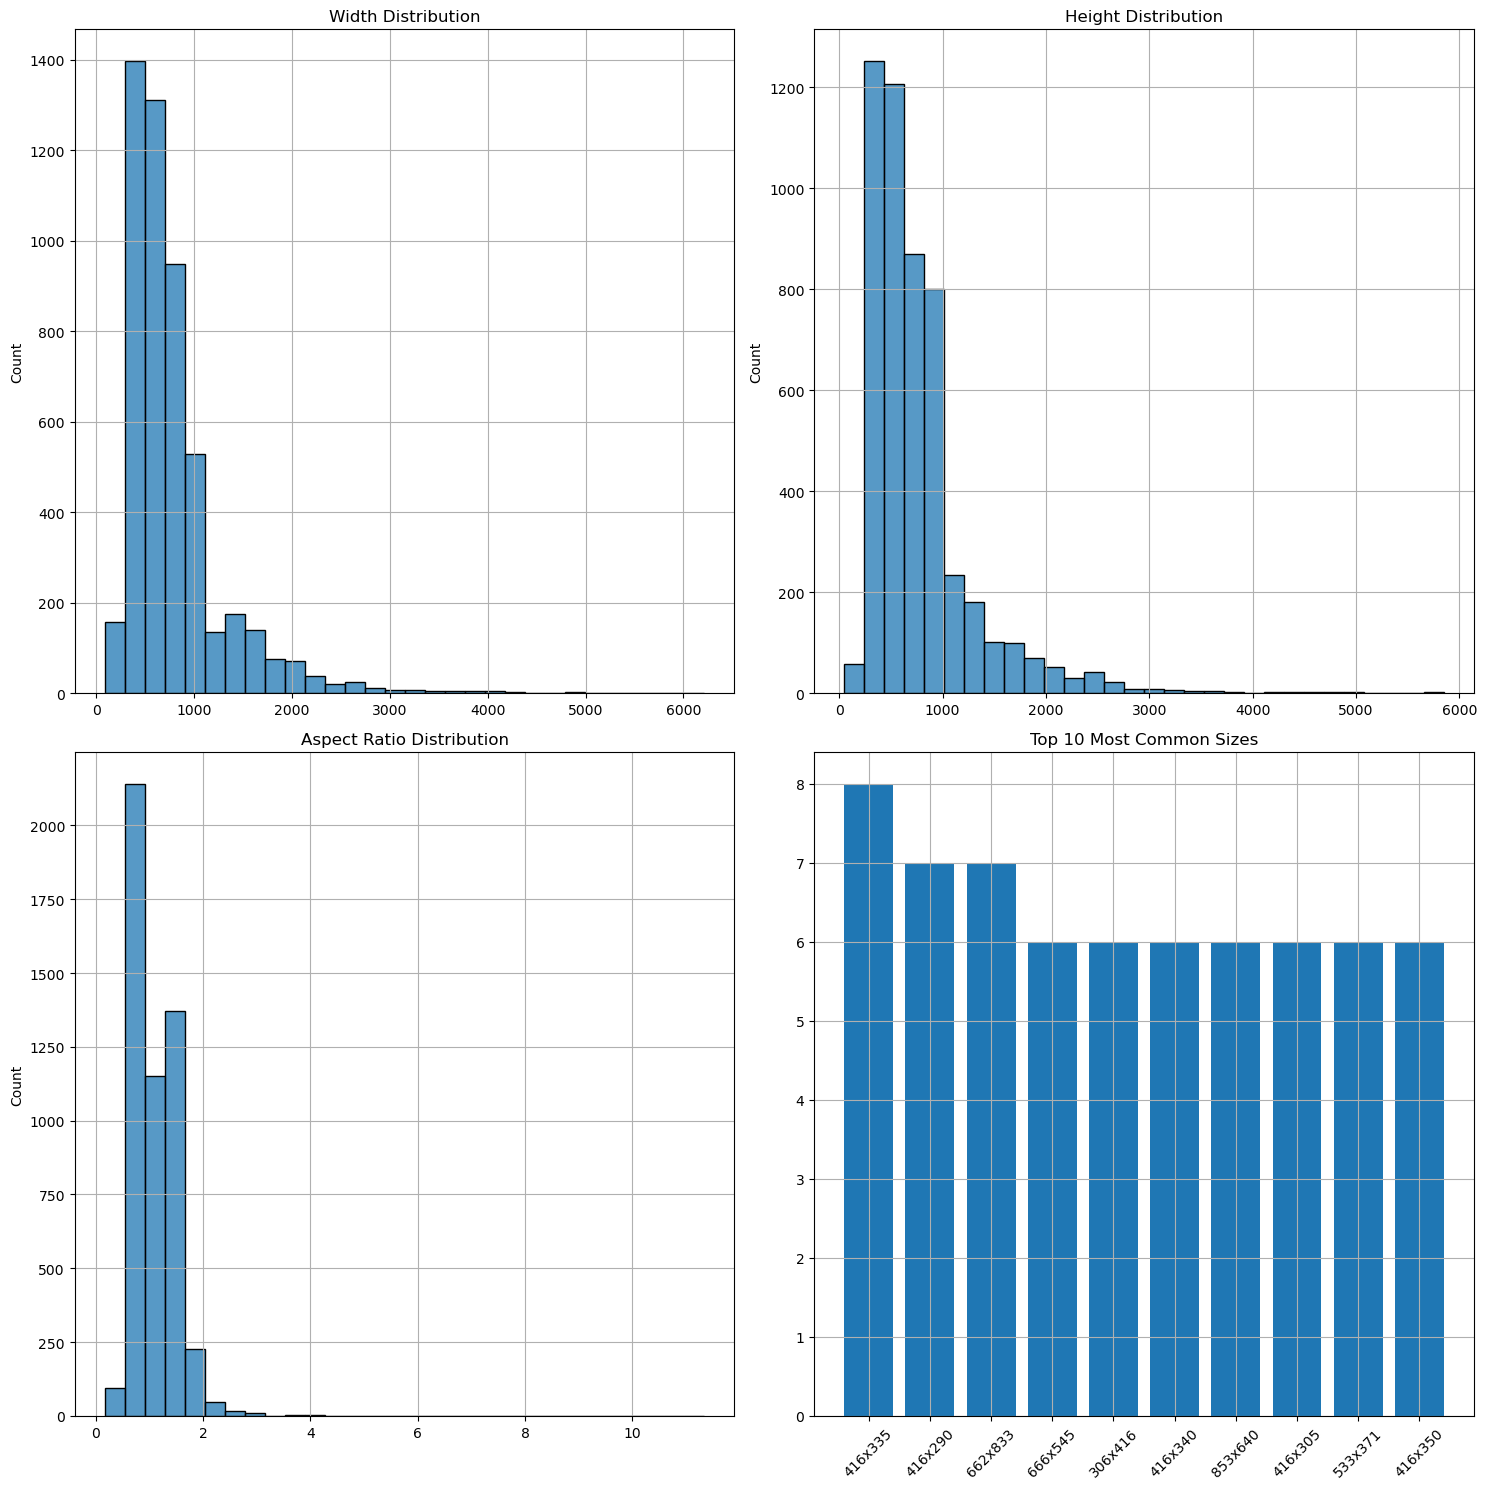

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

def analyze_images(directory):
    widths = []
    heights = []
    aspect_ratios = []
    sizes = defaultdict(int)

    # Process all image files in directory
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                try:
                    img_path = os.path.join(root, file)
                    with Image.open(img_path) as img:
                        width, height = img.size
                        aspect_ratio = width / height

                        widths.append(width)
                        heights.append(height)
                        aspect_ratios.append(aspect_ratio)
                        sizes[f"{width}x{height}"] += 1
                except Exception as e:
                    print(f"Error processing {os.path.basename(img_path)}: {str(e)}")

    return widths, heights, aspect_ratios, sizes

def print_stats(data, name):
    print(f"{name} stats:")
    print(f"  Min: {min(data)}")
    print(f"  Max: {max(data)}")
    print(f"  Mean: {np.mean(data):.2f}")
    print(f"  Median: {np.median(data):.2f}")
    print(f"  Standard deviation: {np.std(data):.2f}")

def plot_distributions(widths, heights, aspect_ratios, sizes):
    
    # Create a figure with subplots
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    
    # Plot distributions
    sns.histplot(widths, bins=30, ax=axs[0,0])
    axs[0,0].set_title('Width Distribution')
    axs[0,0].grid(True)
    
    sns.histplot(heights, bins=30, ax=axs[0,1])
    axs[0,1].set_title('Height Distribution')
    axs[0,1].grid(True)
    
    sns.histplot(aspect_ratios, bins=30, ax=axs[1,0])
    axs[1,0].set_title('Aspect Ratio Distribution')
    axs[1,0].grid(True)
    
    # Plot top 10 most common sizes
    top_sizes = dict(sorted(sizes.items(), key=lambda x: x[1], reverse=True)[:10])
    axs[1,1].bar(range(len(top_sizes)), list(top_sizes.values()))
    axs[1,1].set_xticks(range(len(top_sizes)))
    axs[1,1].set_xticklabels(list(top_sizes.keys()), rotation=45)
    axs[1,1].set_title('Top 10 Most Common Sizes')
    axs[1,1].grid(True)
    
    plt.tight_layout()
    plt.show()

image_directory = inpainting_dest = 'mask_images/inpainting'

# Analyze images
widths, heights, aspect_ratios, sizes = analyze_images(image_directory)

# Print statistics
print_stats(widths, "Width")
print_stats(heights, "Height")
print_stats(aspect_ratios, "Aspect Ratio")

print("\nMost common image sizes:")
for size, count in sorted(sizes.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"  {size}: {count}")

print(f"\nTotal number of images analyzed: {len(widths)}")

# Plot distributions
plot_distributions(widths, heights, aspect_ratios, sizes)

In [5]:
import cv2
def load_image_paths_from_folder(folder, label):
    image_paths = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith((".png", ".jpg", ".jpeg")):
            img_path = os.path.join(folder, filename)
            image_paths.append(img_path)
            labels.append(label)
    return image_paths, labels

# Load real image paths (label = 1)
# real_folder = "extracted_images/original"
real_folder = "mask_images/original"
real_image_paths, real_labels = load_image_paths_from_folder(real_folder, label=1)

# Load fake image paths (label = 0)
# fake_folder = "extracted_images/inpainting"
fake_folder = "mask_images/inpainting"
fake_image_paths, fake_labels = load_image_paths_from_folder(fake_folder, label=0)

# Combine real and fake image paths and labels
image_paths = real_image_paths + fake_image_paths
labels = real_labels + fake_labels

# Convert labels to NumPy array
labels = np.array(labels)

# Check number of images loaded
print(f"Number of real images: {len(real_image_paths)}")
print(f"Number of fake images: {len(fake_image_paths)}")
print(f"Total number of images: {len(image_paths)}")

# Function to load and preprocess images (to be used when training the model)
def load_and_preprocess_image(image_path, target_size=(256, 256), preserve_texture=True):
    img = Image.open(image_path)
    img = img.convert('RGB')  # Convert to RGB
    if preserve_texture:
        # Convert to numpy array for OpenCV processing
        img_array = np.array(img)
        
        # Use Lanczos resampling which better preserves high-frequency details
        img_array = cv2.resize(
            img_array, 
            target_size, 
            interpolation=cv2.INTER_LANCZOS4
        )
    else:
        img = img.resize(target_size)  # Resize the image
        img_array = np.array(img)

    img_array = img_array.astype(np.float32)
    img_array /= 255.0  # Normalize to [0, 1]
    return img_array

Number of real images: 5063
Number of fake images: 5063
Total number of images: 10126


In [6]:
from numpy import random
# Test the preprocessing function
test_image_path = random.choice(image_paths)  # Choose a random image
processed_image = load_and_preprocess_image(test_image_path)

print(f"Processed image shape: {processed_image.shape}")
print(f"Min pixel value: {processed_image.min()}")
print(f"Max pixel value: {processed_image.max()}")
print(f"Mean pixel value: {processed_image.mean()}")

Processed image shape: (256, 256, 3)
Min pixel value: 0.0
Max pixel value: 1.0
Mean pixel value: 0.1907576322555542


In [7]:
from sklearn.model_selection import train_test_split
# Perform train-test split
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

# Print the shapes of the resulting datasets
print("\nAfter train-test split:")
print(f"Train set size: {len(train_paths)}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test set size: {len(test_paths)}")
print(f"Test labels shape: {test_labels.shape}")

# Print the distribution of labels in train and test sets
print(f"\nTrain set - Real: {np.sum(train_labels == 1)}, Fake: {np.sum(train_labels == 0)}")
print(f"Test set - Real: {np.sum(test_labels == 1)}, Fake: {np.sum(test_labels == 0)}")


After train-test split:
Train set size: 8100
Train labels shape: (8100,)
Test set size: 2026
Test labels shape: (2026,)

Train set - Real: 4050, Fake: 4050
Test set - Real: 1013, Fake: 1013


In [8]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [9]:
model = Sequential()

# Convolution Layer 1
model.add(Conv2D(32, (5, 5), input_shape=(256, 256, 3)))  # Changed input shape to (224, 224, 3)
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))

# Convolution Layer 2
model.add(Conv2D(32, (5, 5)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolution Layer 3
model.add(Conv2D(64, (5, 5)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))

# Convolution Layer 4
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolution Layer 5
model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolution Layer 6
model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolution Layer 7
model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

# Fully Connected Layer 8
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Fully Connected Layer 9
model.add(Dropout(0.5))
model.add(Dense(1))  # 1 unit for binary classification
model.add(Activation('sigmoid'))  # sigmoid for binary classification

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2

def improved_deepfake_detection_model(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)
    
    # Convolutional layers
    x = Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Additional convolutional layer
    x = Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)
    
    # Dense layers
    x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.6)(x)
    
    # Final layer
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create the model
model = improved_deepfake_detection_model()

# Print model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496 

In [10]:
from tensorflow.keras.optimizers import Adam


model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.00025), metrics=['accuracy'])
# train_gen = ImageDataGenerator(  preprocessing_function=lambda x: x / 255.0  # Normalize pixel values
# )

train_gen = ImageDataGenerator(
    rotation_range=5,    
    width_shift_range=0.1,     
    height_shift_range=0.1,
    horizontal_flip=False,  
    zoom_range=0.1,
    shear_range=0.0, 
    fill_mode='constant',  
    cval=0,                   # Black padding for constant fill mode
)

# train_gen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
#     zoom_range=0.2,
#     shear_range=0.2,
#     fill_mode='nearest'
# )

test_gen = ImageDataGenerator()

# Custom generator function
def custom_generator(features, labels, batch_size, gen, is_training=False, target_size=(256, 256)):
    while True:
        batch_indices = np.random.choice(len(features), batch_size)
        batch_features = np.array([load_and_preprocess_image(features[i], target_size) for i in batch_indices])
        batch_labels = labels[batch_indices]
        
        # Apply data augmentation only for training generator
        if is_training:
            batch_features, batch_labels = next(gen.flow(batch_features, batch_labels, batch_size=batch_size))
        
        yield batch_features, batch_labels

# Create generators
train_generator = custom_generator(train_paths, train_labels, batch_size=32, gen=train_gen, is_training=True, target_size=(256, 256))
test_generator = custom_generator(test_paths, test_labels, batch_size=32, gen=test_gen, is_training=False, target_size=(256, 256))

In [11]:
# Test the custom generator
train_generator = custom_generator(train_paths, train_labels, batch_size=32, gen=train_gen, is_training=True, target_size=(256, 256))
test_generator = custom_generator(test_paths, test_labels, batch_size=32, gen=test_gen, is_training=False, target_size=(256, 256))

# Check a batch from each generator
train_batch_x, train_batch_y = next(train_generator)
test_batch_x, test_batch_y = next(test_generator)

print("Training batch:")
print(f"X shape: {train_batch_x.shape}, Y shape: {train_batch_y.shape}")
print(f"X min: {train_batch_x.min()}, X max: {train_batch_x.max()}, X mean: {train_batch_x.mean()}")
print(f"Y values: {np.unique(train_batch_y)}")

print("\nTesting batch:")
print(f"X shape: {test_batch_x.shape}, Y shape: {test_batch_y.shape}")
print(f"X min: {test_batch_x.min()}, X max: {test_batch_x.max()}, X mean: {test_batch_x.mean()}")
print(f"Y values: {np.unique(test_batch_y)}")

Training batch:
X shape: (32, 256, 256, 3), Y shape: (32,)
X min: 0.0, X max: 1.0, X mean: 0.2070801854133606
Y values: [0 1]

Testing batch:
X shape: (32, 256, 256, 3), Y shape: (32,)
X min: 0.0, X max: 1.0, X mean: 0.2344072312116623
Y values: [0 1]


In [12]:
import tensorflow as tf

class GradientCheck(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        weights = self.model.get_weights()
        has_nan = any(np.isnan(w).any() for w in weights)
        has_inf = any(np.isinf(w).any() for w in weights)
        print(f"Epoch {epoch+1}: NaN in weights: {has_nan}, Inf in weights: {has_inf}")

class LayerOutputCheck(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Get the output of the last layer (which should be the sigmoid output)
        layer_output = tf.keras.backend.function([self.model.input], [self.model.output])
        sample_data, sample_labels = next(train_generator)  # Get a batch of data and labels
        output = layer_output([sample_data])[0]
        
        # Calculate accuracy on this batch
        predicted_classes = (output > 0.5).astype(int)
        accuracy = np.mean(predicted_classes == sample_labels)
        
        print(f"Epoch {epoch+1}: Output range: {output.min():.4f} to {output.max():.4f}, Mean: {output.mean():.4f}")
        print(f"Batch accuracy: {accuracy:.4f}")
        print(f"Output distribution: {np.sum(output < 0.1)} < 0.1, {np.sum((output >= 0.1) & (output < 0.9))} in [0.1, 0.9), {np.sum(output >= 0.9)} >= 0.9")

class PrintProgress(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}: loss: {logs['loss']:.4f} - accuracy: {logs['accuracy']:.4f} - val_loss: {logs['val_loss']:.4f} - val_accuracy: {logs['val_accuracy']:.4f}")

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

# Create a directory to save model weights if it doesn't exist
weights_dir = "model_weights"
os.makedirs(weights_dir, exist_ok=True)

# Define the file path for saving the model weights
checkpoint_filepath = os.path.join(weights_dir, "model_weights_epoch_{epoch:02d}_val_loss_{val_loss:.2f}.weights.h5")

# Create a ModelCheckpoint callback to save the best model weights
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,  # Save only weights, not the entire model
    save_best_only=True,  # Only save the best model
    monitor='val_loss',  # Metric to monitor
    mode='min',  # 'min' for loss, 'max' for accuracy
    verbose=1
)

# Create an EarlyStopping callback to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,
    verbose=1
)

# Create a ReduceLROnPlateau callback to reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,  # Factor by which the learning rate will be reduced
    patience=2,  # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,  # Lower bound on the learning rate
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_paths) // 32,
    epochs=25,
    validation_data=test_generator,
    validation_steps=len(test_paths) // 32,
    callbacks=[model_checkpoint_callback, early_stopping, reduce_lr, GradientCheck(), LayerOutputCheck(), PrintProgress()]
)

# Save the final model weights
final_weights_path = os.path.join(weights_dir, "final_model_weights.weights.h5")
model.save_weights(final_weights_path)
print(f"Final model weights saved to {final_weights_path}")

Epoch 1/25
253/253 [==============================] - ETA: 0s - loss: 0.9492 - accuracy: 0.6020
Epoch 1: val_loss improved from inf to 1.80840, saving model to model_weights\model_weights_epoch_01_val_loss_1.81.weights.h5
Epoch 1: NaN in weights: False, Inf in weights: False
Epoch 1: Output range: 0.0054 to 0.1181, Mean: 0.0357
Batch accuracy: 0.4062
Output distribution: 31 < 0.1, 1 in [0.1, 0.9), 0 >= 0.9
Epoch 1: loss: 0.9492 - accuracy: 0.6020 - val_loss: 1.8084 - val_accuracy: 0.4901
253/253 [==============================] - 334s 1s/step - loss: 0.9492 - accuracy: 0.6020 - val_loss: 1.8084 - val_accuracy: 0.4901 - lr: 2.5000e-04
Epoch 2/25
253/253 [==============================] - ETA: 0s - loss: 0.8474 - accuracy: 0.6459
Epoch 2: val_loss improved from 1.80840 to 1.59836, saving model to model_weights\model_weights_epoch_02_val_loss_1.60.weights.h5
Epoch 2: NaN in weights: False, Inf in weights: False
Epoch 2: Output range: 0.0021 to 0.8098, Mean: 0.0699
Batch accuracy: 0.6094
O

In [15]:
model = improved_deepfake_detection_model()  # Your model definition function
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
path_to_weight = 'model_weights_epoch_04_val_loss_0.57.weights.h5'
model.load_weights(f'model_weights/{path_to_weight}')

In [56]:
print(model.get_weights()[0])  # Should not be zero or very small

[[[[ 7.73816407e-02  5.01237474e-02  1.16345897e-01 -4.25487943e-02
    -1.12312265e-01 -2.52073165e-02 -1.08668365e-01  2.54704859e-02
    -1.15379356e-02  7.03672096e-02 -2.36934889e-02 -8.12853277e-02
    -3.20539623e-02  2.03140569e-03  6.91335276e-02  7.64771476e-02
     2.72166766e-02 -8.00706595e-02 -7.66317919e-02  4.69055064e-02
     1.40564963e-02 -5.43137044e-02 -1.18410893e-01  3.46240364e-02
    -5.27308770e-02  3.98482420e-02  1.22120813e-01 -1.32752312e-02
    -7.42192343e-02  4.21289131e-02 -9.82094556e-02  1.27430409e-01]
   [-1.13485917e-01 -1.27089903e-01 -1.31917208e-01  9.78823565e-03
    -6.48729131e-02  9.87079442e-02 -1.74333453e-02 -5.40644377e-02
     6.54416382e-02  8.71845186e-02  1.21347075e-02 -1.32930323e-01
     6.62973598e-02  7.85671324e-02 -5.66288643e-02  1.26101211e-01
     2.05058530e-02  1.21010564e-01 -1.05350964e-01  1.38661429e-01
    -7.03356415e-03 -1.30386114e-01 -1.25803292e-01 -5.22602648e-02
    -7.34521970e-02  6.46872595e-02 -8.42533261

In [12]:
for i, layer in enumerate(model.layers):
    weights = layer.get_weights()
    print(f"Layer {i} ({layer.name}) weights: {[w.shape for w in weights]}")

Layer 0 (input_2) weights: []
Layer 1 (conv2d_4) weights: [(3, 3, 3, 32), (32,)]
Layer 2 (batch_normalization_6) weights: [(32,), (32,), (32,), (32,)]
Layer 3 (activation_4) weights: []
Layer 4 (max_pooling2d_4) weights: []
Layer 5 (conv2d_5) weights: [(3, 3, 32, 64), (64,)]
Layer 6 (batch_normalization_7) weights: [(64,), (64,), (64,), (64,)]
Layer 7 (activation_5) weights: []
Layer 8 (max_pooling2d_5) weights: []
Layer 9 (conv2d_6) weights: [(3, 3, 64, 128), (128,)]
Layer 10 (batch_normalization_8) weights: [(128,), (128,), (128,), (128,)]
Layer 11 (activation_6) weights: []
Layer 12 (max_pooling2d_6) weights: []
Layer 13 (conv2d_7) weights: [(3, 3, 128, 256), (256,)]
Layer 14 (batch_normalization_9) weights: [(256,), (256,), (256,), (256,)]
Layer 15 (activation_7) weights: []
Layer 16 (max_pooling2d_7) weights: []
Layer 17 (global_average_pooling2d_1) weights: []
Layer 18 (dense_3) weights: [(256, 256), (256,)]
Layer 19 (batch_normalization_10) weights: [(256,), (256,), (256,), (256

In [14]:
def test_generator(image_paths, labels, batch_size=32):
    num_samples = len(image_paths)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_paths = image_paths[offset:offset+batch_size]
            batch_labels = labels[offset:offset+batch_size]
            
            batch_images = np.array([load_and_preprocess_image(path) for path in batch_paths])
            
            yield batch_images, batch_labels

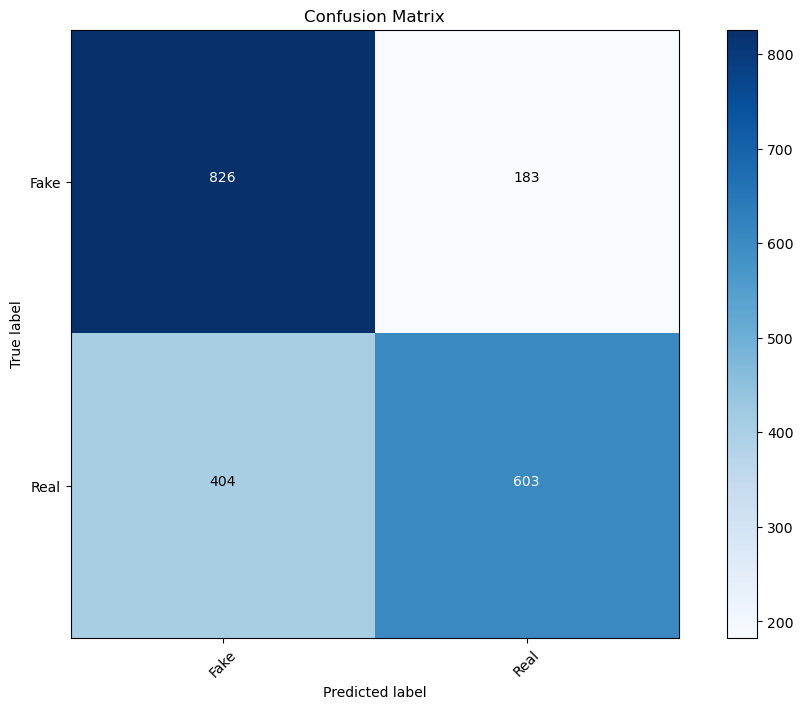


Classification Report:
              precision    recall  f1-score   support

        Fake       0.67      0.82      0.74      1009
        Real       0.77      0.60      0.67      1007

    accuracy                           0.71      2016
   macro avg       0.72      0.71      0.71      2016
weighted avg       0.72      0.71      0.71      2016


Accuracy: 0.7088
AUC-ROC: 0.7885


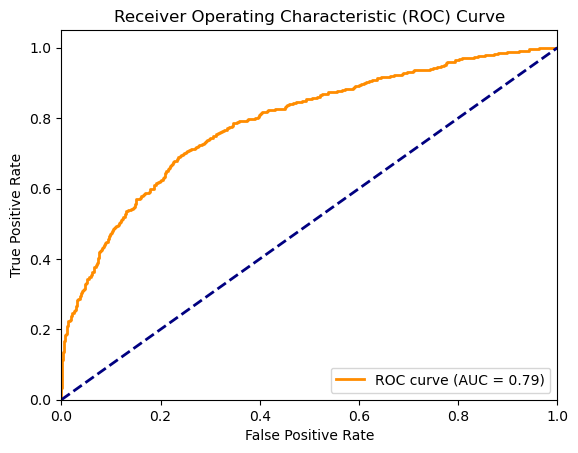

In [16]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve

# Function to get predictions and true labels
def get_predictions_and_labels(generator, num_samples, batch_size):
    steps = num_samples // batch_size
    y_pred = []
    y_true = []
    for _ in range(steps):
        batch_x, batch_y = next(generator)
        batch_pred = model.predict(batch_x, verbose=0)
        y_pred.extend(batch_pred)
        y_true.extend(batch_y)
    return np.array(y_pred).flatten(), np.array(y_true)

# Create the test generator
test_gen = test_generator(test_paths, test_labels, batch_size=32)

# Get predictions and true labels
num_test_samples = len(test_paths)
y_pred, y_true = get_predictions_and_labels(test_gen, num_test_samples, batch_size=32)

# Convert predictions to classes
y_pred_classes = (y_pred > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10,7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Fake', 'Real'], rotation=45)
plt.yticks(tick_marks, ['Fake', 'Real'])

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=['Fake', 'Real']))

# Print accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"\nAccuracy: {accuracy:.4f}")

# Print AUC-ROC
auc_roc = roc_auc_score(y_true, y_pred)
print(f"AUC-ROC: {auc_roc:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

1/1 [==============================] - 0s 295ms/step


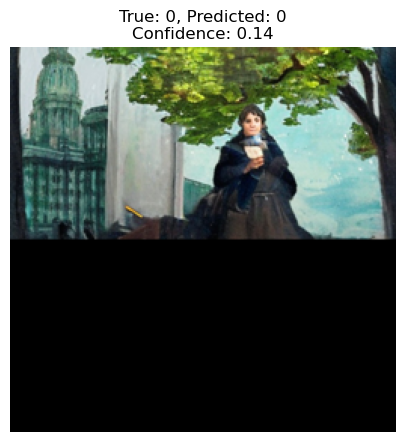

1/1 [==============================] - 0s 17ms/step


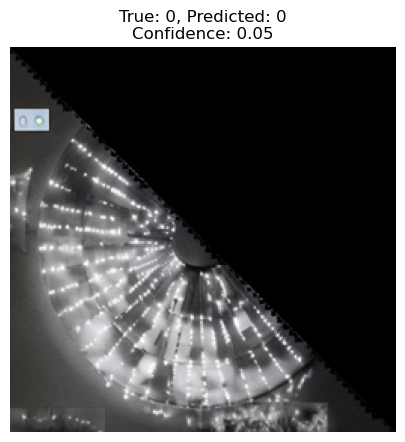

1/1 [==============================] - 0s 15ms/step


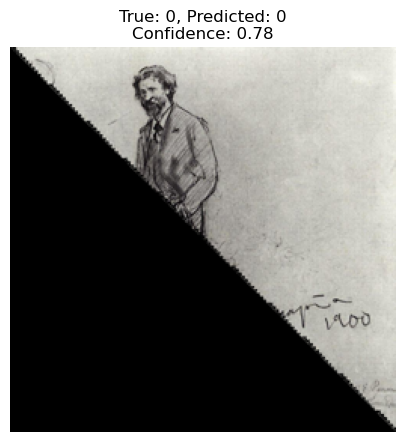

1/1 [==============================] - 0s 17ms/step


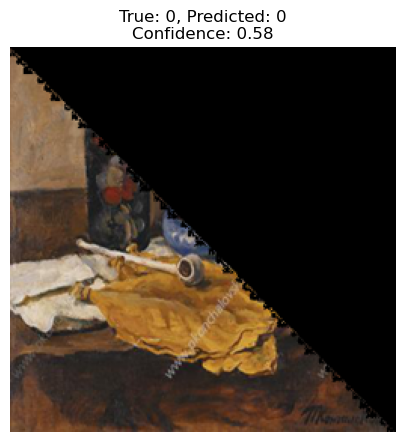

1/1 [==============================] - 0s 17ms/step


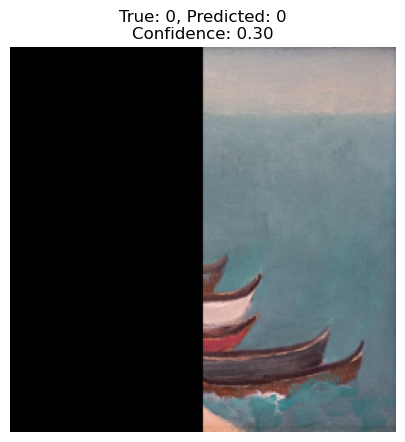

1/1 [==============================] - 0s 20ms/step


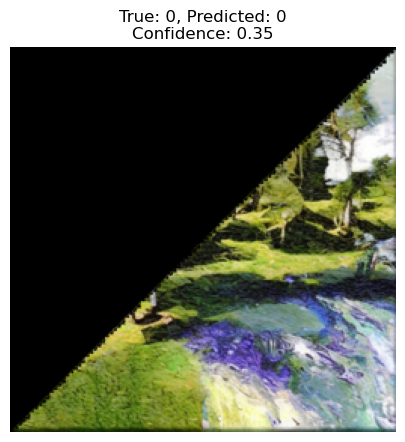

1/1 [==============================] - 0s 15ms/step


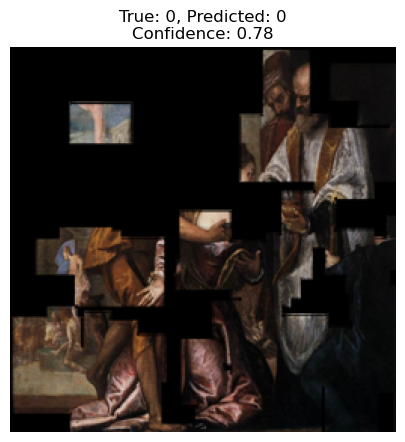

1/1 [==============================] - 0s 16ms/step


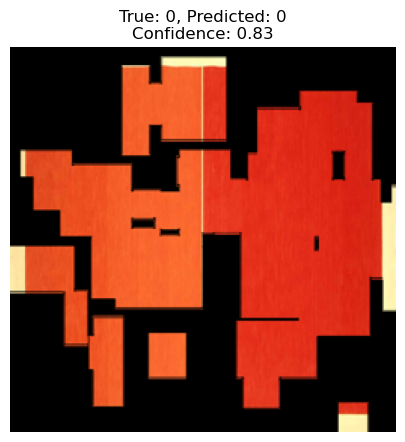

1/1 [==============================] - 0s 20ms/step


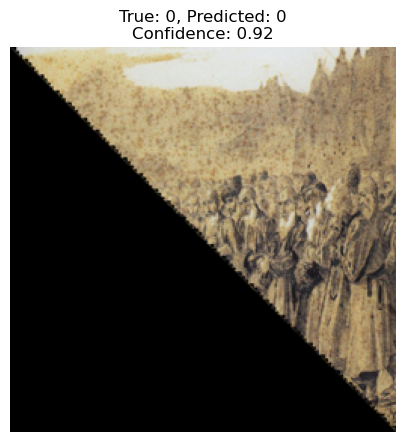

1/1 [==============================] - 0s 15ms/step


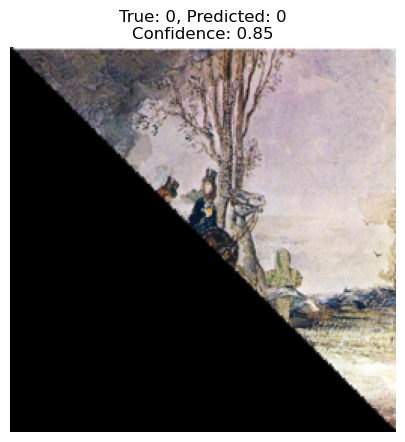

In [20]:
def visualize_predictions(model, test_paths, test_labels, num_samples=10):
    # Randomly select samples
    indices = np.random.choice(len(test_paths), num_samples, replace=False)
    
    for idx in indices:
        # Load and preprocess the image
        img = load_and_preprocess_image(test_paths[idx])
        img_batch = np.expand_dims(img, axis=0)
        
        # Make prediction
        prediction = model.predict(img_batch)[0]
        predicted_class = np.argmax(prediction)
        true_class = np.argmax(test_labels[idx])
        
        # Display the image and prediction
        plt.figure(figsize=(10, 5))
        plt.imshow(img)
        plt.title(f"True: {true_class}, Predicted: {predicted_class}\nConfidence: {prediction[predicted_class]:.2f}")
        plt.axis('off')
        plt.show()

# Call the function
visualize_predictions(model, test_paths, test_labels)